# 251a Programming project 1: Prototype Selection for Nearest Neighbor

Nearest neighbor classification can be accelerated by replacing the entire training set with a carefully chosen subset of prototypes. The challenge lies in selecting prototypes that are representative enough to ensure good classification performance on test data. Several methods can be employed for prototype selection, each with its own characteristics.

## Properties of Effective Prototype Sets

- **Representativeness:** Prototypes should capture the diversity and characteristics of different classes in the dataset.
- **Robustness:** The selected prototypes should be robust to noise and outliers, ensuring stability in classification.
- **Generalization:** Prototypes should generalize well to unseen data, enhancing the model's ability to classify diverse examples.
- **Efficiency:** The chosen prototypes should lead to faster search times without significantly sacrificing accuracy.

## Formalizing Prototype Selection

1. Method 1: **K-Means Clustering:** Use K-Means clustering to identify centroids that represent different clusters in the dataset. Select prototypes based on these centroids.

2. Method 2: **Modified Condensed Nearest Neighbors (MCNN):** Iteratively flag and remove misclassified instances. Add representative centroids of misclassified examples from each class to the prototype set.

3. Method 3: **Reduced Nearest Neighbors (RNN):** Remove instances from the set if their removal does not cause misclassification in the remaining training set. Create a subset that ensures classification accuracy.

4. Method 4: **Generalized Condensed Nearest Neighbor (GCNN):** Employ a voting mechanism to choose initial prototypes. Apply the CNN rule, considering class and distance criteria, to refine the prototype set.

## Implementation and Testing

- Implement the prototype selection algorithms using the MNIST dataset.
- Evaluate the performance of each method using 1-NN for classification.
- Measure and compare classification accuracy, search efficiency, and other relevant metrics.

By considering the properties of effective prototype sets and formalizing the selection process, the goal is to enhance the efficiency of nearest neighbor classification while maintaining or improving accuracy on test data.


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import json
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
import struct
from array import array
from os.path  import join
import pickle as pkl
from tqdm import tqdm
import matplotlib.pyplot as plt

## Reading the data

In [2]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)        

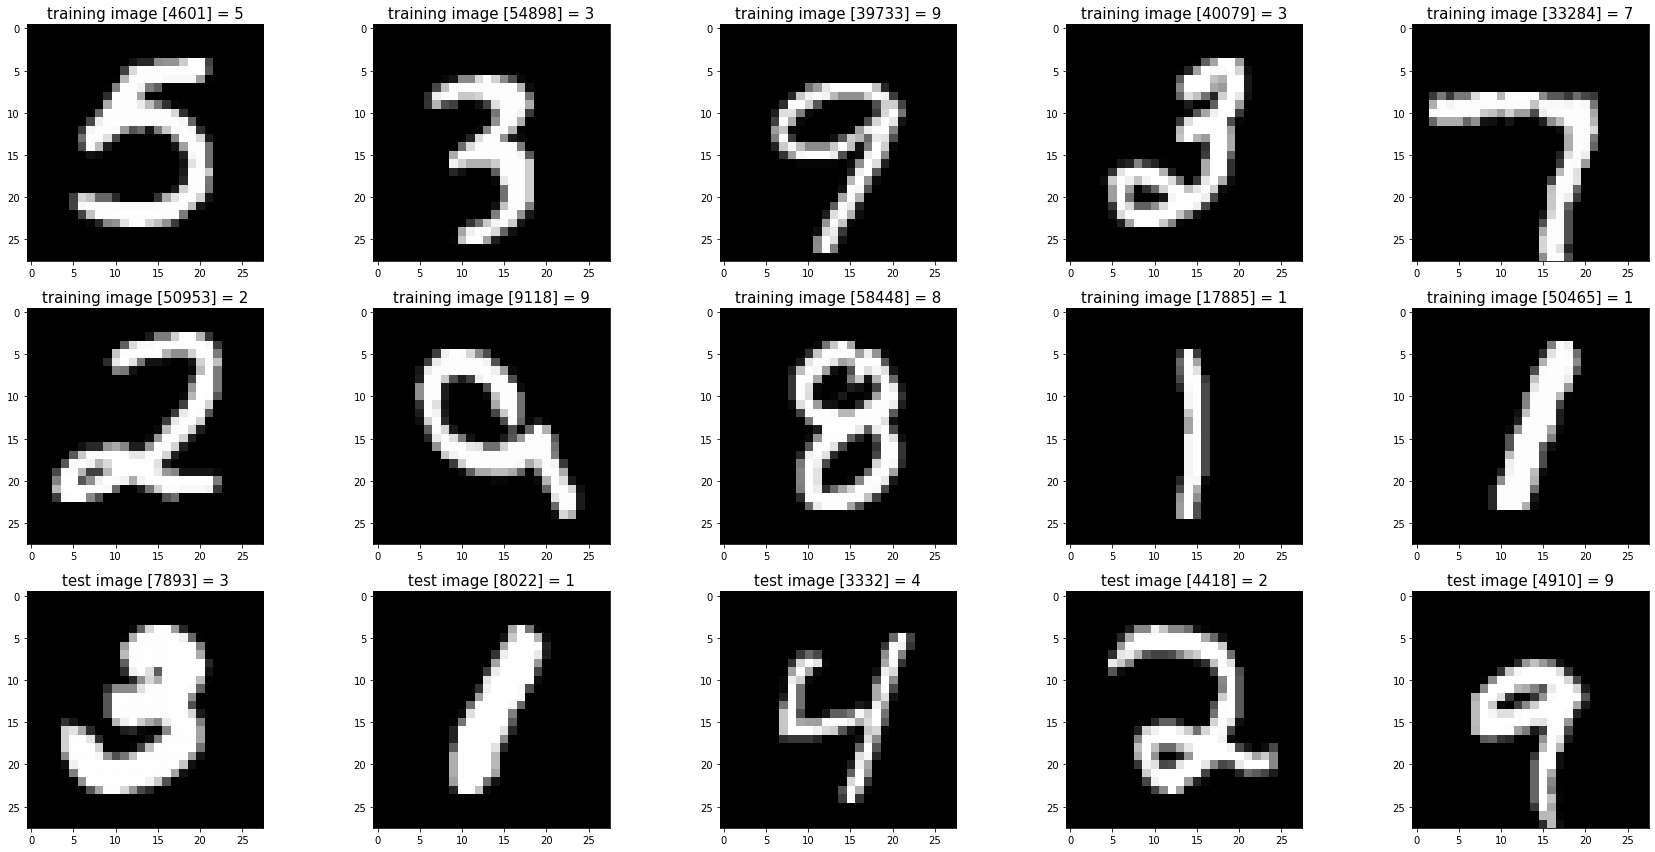

In [3]:

# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = 'data'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

# Baseline
## Randomly Selecting Data :
* Uses scikit-learn's KNeighborsClassifier with k=1 (1-nearest neighbor).
* Trains the classifier on the training data.
* Makes predictions on the test data.
* Evaluates the accuracy of the classifier using accuracy_score from scikit-learn.


In [36]:
x_train=np.asarray(x_train)
x_train=x_train.reshape(60000,784)
x_test=np.asarray(x_test)
x_test=x_test.reshape(10000,784)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [37]:
y_train.reshape(-1,1).shape

(60000, 1)

In [38]:
def nearest_neighbor(train, test):
    k_value = 1
    knn_classifier = KNeighborsClassifier(n_neighbors=k_value)

    x_train, y_train = train
    x_test, y_test = test
    # Train the classifier on the training data
    knn_classifier.fit(x_train, y_train)

    # Make predictions on the test data
    y_pred = knn_classifier.predict(x_test)

    # Evaluate the accuracy of the classifier
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [89]:
def generate_random_samples(x_train, y_train, n_samples, random_state=None):
    # Randomly select samples from the training set
    index = np.random.choice(len(x_train), n_samples, replace=False)
    x_random_sample = x_train[index]
    y_random_sample = y_train[index]

    return (x_random_sample, y_random_sample), (x_test, y_test)

baseline_accuracies = []
for M in [500, 1000, 2500, 5000, 10000, 20000]:
    
        baseline_trial_accuracies=[]
        x_train_random, y_train_random = generate_random_samples(x_train, y_train, M)
        accuracy = nearest_neighbor(x_train_random, y_train_random)
        baseline_accuracies.append(accuracy)
        
        print(f'Accuracy for M: {M}  = {accuracy}')

print(baseline_accuracies)

Accuracy for M: 500  = 0.8526
Accuracy for M: 1000  = 0.8864
Accuracy for M: 2500  = 0.915
Accuracy for M: 5000  = 0.9346
Accuracy for M: 10000  = 0.9455
Accuracy for M: 20000  = 0.9559
[0.8526, 0.8864, 0.915, 0.9346, 0.9455, 0.9559]


# Method: Prototypes Selection using K-Means Clustering
* Function uses K-Means clustering to select prototypes from input data.
* It supports both performing K-Means clustering and using a pretrained model.
* Prototypes are chosen as the closest data points to the cluster centers.
* The number of prototypes per cluster is determined.


In [74]:
def select_prototypes_clustering(X, data_points, clusters = 10, save = None, pretrained=False, pretrained_path = None):
    # Step 1: Apply K-Means clustering
    if pretrained:
        with open(pretrained_path, "rb") as file:
            kmeans = pkl.load(file)
        clusters = len(kmeans.cluster_centers_)
    else:
        kmeans = KMeans(n_clusters=clusters, random_state=42)
        kmeans.fit(X)
        if save is not None:
            with open(save, "wb") as file:
                pkl.dump(kmeans, file)
            
    point_per_cluster = data_points//clusters
    # Step 2: Choose one representative from each cluster as a prototype
    prototypes = []
    for cluster_center in kmeans.cluster_centers_:
        # Find the nearest data point to the cluster center
        closest_point_idx = np.argsort(np.linalg.norm(X - cluster_center, axis=1))[:point_per_cluster]
        prototypes.extend(closest_point_idx)
    
    return prototypes

In [95]:
samples_sizes = [500, 1000, 2500, 5000, 10000]
results = {"clusters": [], "samples": [], "accuracy": []}
num_clusters_list = [10, 50]

for num_clusters in tqdm(num_clusters_list):
    print('---------------------------------')
    for sample_size in samples_sizes:
        # Select prototypes using clustering
        selected_indexes = select_prototypes_clustering(x_train, sample_size, num_clusters, save='project251a', pretrained=False, pretrained_path=f"kmeans_{num_clusters}.pkl")
        selected_data = (x_train[selected_indexes], y_train[selected_indexes])
        
        # Evaluate accuracy with nearest neighbor
        test_data = (x_test, y_test)
        accuracy = nearest_neighbor(selected_data, test_data) * 100

        # Print and store results
        print(f"Cluster size: {num_clusters}, Accuracy for {sample_size}: = {accuracy} ")
        results["clusters"].append(num_clusters)
        results["samples"].append(sample_size)
        results["accuracy"].append(accuracy)

  0%|          | 0/2 [00:00<?, ?it/s]

---------------------------------
Cluster size: 10, Accuracy for 500: = 68.66 
Cluster size: 10, Accuracy for 1000: = 74.07000000000001 
Cluster size: 10, Accuracy for 2500: = 77.96 
Cluster size: 10, Accuracy for 5000: = 81.76 


 50%|█████     | 1/2 [02:53<02:53, 173.58s/it]

Cluster size: 10, Accuracy for 10000: = 85.71 
---------------------------------
Cluster size: 50, Accuracy for 500: = 83.76 
Cluster size: 50, Accuracy for 1000: = 85.88 
Cluster size: 50, Accuracy for 2500: = 88.86 
Cluster size: 50, Accuracy for 5000: = 90.46 


100%|██████████| 2/2 [15:41<00:00, 470.63s/it]

Cluster size: 50, Accuracy for 10000: = 91.8 


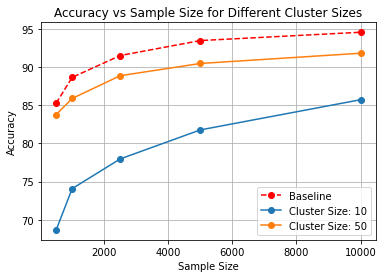

In [104]:
# Plotting
sample_sizes = [500, 1000, 2500, 5000, 10000]
baseline_accuracies = [0.8526, 0.8864, 0.915, 0.9346, 0.9455]
baseline_accuracies = [i*100 for i in baseline_accuracies]
plt.plot(sample_sizes, baseline_accuracies, marker='o', linestyle='--', color='red', label='Baseline')
for cluster_size in num_clusters_list:
    # Filter results for the current cluster size
    cluster_results = [(s, acc) for s, acc, c in zip(results["samples"], results["accuracy"], results["clusters"]) if c == cluster_size]

    # Extract data for plotting
    x_vals = [s for s, _ in cluster_results]
    y_vals = [acc for _, acc in cluster_results]

    # Plot the data
    plt.plot(x_vals, y_vals, marker='o', label=f'Cluster Size: {cluster_size}')

plt.plot()
# Adding labels and title
plt.title('Accuracy vs Sample Size for Different Cluster Sizes')
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')

# Adding legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

## Method: Modified Condensed Nearest Neighbors (MCNN)

- **Algorithm Description:**
  - MCNN is a variant of the Condensed Nearest Neighbors (CNN) algorithm.
  - Instead of adding an instance to the set S when it is misclassified, MCNN flags all misclassified instances.
  - After testing all instances in the training set (TR), representative examples of each class are added to S.
  - The representative examples are generated as centroids of the misclassified examples in each class.

In [45]:
def modified_cnn(x_train, y_train):
    misclassified = True

    while misclassified:
        misclassified = False
        misclassified_indices = []

        knn_classifier = KNeighborsClassifier(n_neighbors=1)
        knn_classifier.fit(x_train, y_train)

        for i, (x, y) in enumerate(zip(x_train, y_train)):
            x_instance = x.reshape(1, -1)
            y_pred = knn_classifier.predict(x_instance)

            if y_pred != y:
                misclassified = True
                misclassified_indices.append(i)

        if misclassified:
            # Add representative examples as centroids
            for class_label in np.unique(y_train):
                class_indices = [idx for idx in misclassified_indices if y_train[idx] == class_label]
                if class_indices:
                    representative_example = np.mean(x_train[class_indices], axis=0)
                    x_train = np.vstack([x_train, representative_example])
                    y_train = np.append(y_train, class_label)

    return x_train, y_train

In [34]:
# Different numbers of samples to test
sample_sizes = [500, 1000, 2500, 5000, 10000, 20000]
mccn_accuracies = []

for sample_size in tqdm(sample_sizes):
    # Select a subset of the training data
    x_train_subset, y_train_subset = x_train[:sample_size], y_train[:sample_size]

    # Apply reduced_nn function
    x_train_mcnn, y_train_mcnn = modified_cnn(x_train_subset, y_train_subset)

    # Apply nearest_neighbor function
    mcnn_accuracy = nearest_neighbor((x_train_mcnn, y_train_mcnn), (x_test, y_test))
    mccn_accuracies.append(mcnn_accuracy)

    print(f'Accuracy for {sample_size}: {mcnn_accuracy}')

print(mcnn_accuracies)

 17%|█▋        | 1/6 [00:09<00:48,  9.67s/it]

Accuracy for 500: 0.8294


 33%|███▎      | 2/6 [00:39<01:25, 21.35s/it]

Accuracy for 1000: 0.869


 50%|█████     | 3/6 [03:03<03:52, 77.46s/it]

Accuracy for 2500: 0.9136


 67%|██████▋   | 4/6 [12:15<08:49, 264.92s/it]

Accuracy for 5000: 0.9343


 83%|████████▎ | 5/6 [44:06<14:18, 858.29s/it]

Accuracy for 10000: 0.9463


100%|██████████| 6/6 [1:50:39<00:00, 1106.59s/it]

Accuracy for 20000: 0.9557
[0.8294, 0.869, 0.9136, 0.9343, 0.9463, 0.9557]


In [87]:
mcnn_accuracies

[0.85, 0.88, 0.91, 0.92, 0.93, 0.94]

In [98]:
mcnn_accuracies = [0.8294, 0.869, 0.9136, 0.9343, 0.9463, 0.9557]

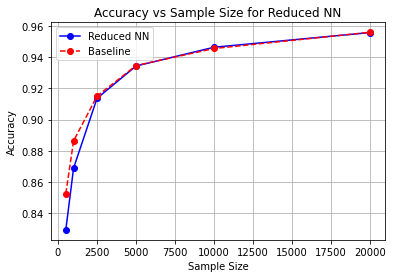

In [99]:

# Plotting the graph

sample_sizes = [500, 1000, 2500, 5000, 10000, 20000]
baseline_accuracies = [0.8526, 0.8864, 0.915, 0.9346, 0.9455, 0.9559]

plt.plot(sample_sizes, mcnn_accuracies, marker='o', linestyle='-', color='blue', label='Reduced NN')
plt.plot(sample_sizes, baseline_accuracies, marker='o', linestyle='--', color='red', label='Baseline')

# Adding labels and title
plt.title('Accuracy vs Sample Size for Reduced NN')
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')

# Adding a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

## Method: Reduced Nearest Neighbors (RNN)

- **Algorithm Description:**
  - RNN is a variant of the Nearest Neighbors algorithm.
  - It starts with the set S being equal to the entire training set TR.
  - It removes each instance from S, ensuring that the removal does not cause any other instances in TR to be misclassified by the instances remaining in S.
  
- **Subset Generation:**
  - RNN generates a subset of instances from the original training set TR.
  - Instances are selectively removed from S to minimize the impact on classification accuracy.

- **Iterative Process:**
  - The algorithm iteratively evaluates the impact of removing each instance.
  - Instances are removed if their absence does not lead to misclassification in the remaining training set.


In [81]:
def reduced_nn(x_train, y_train):
    # Initial set S is the entire training set TR
    S_indices = set(range(len(x_train)))

    knn_classifier = KNeighborsClassifier(n_neighbors=1)
    knn_classifier.fit(x_train, y_train)

    misclassified = True

    while misclassified:
        misclassified = False
        remove_indices = []

        for i in S_indices:
            # Temporarily remove the instance and check for misclassification
            temp_S_indices = S_indices - {i}
            x_temp_S = x_train[list(temp_S_indices)]
            y_temp_S = y_train[list(temp_S_indices)]

            x_instance = x_train[i].reshape(1, -1)
            y_pred = knn_classifier.predict(x_instance)

            if y_pred != y_train[i]:
                misclassified = True
                remove_indices.append(i)

        # Remove instances that don't cause misclassification
        S_indices -= set(remove_indices)

    # Generate a subset of the results of CNN algorithm
    x_train_rnn = x_train[list(S_indices)]
    y_train_rnn = y_train[list(S_indices)]

    return x_train_rnn, y_train_rnn



In [84]:
# Different numbers of samples to test
sample_sizes = [500, 1000, 2500, 5000, 10000, 20000]
rnn_accuracies = []

for sample_size in tqdm(sample_sizes):
    # Select a subset of the training data
    x_train_subset, y_train_subset = x_train[:sample_size], y_train[:sample_size]

    # Apply reduced_nn function
    x_train_reduced, y_train_reduced = reduced_nn(x_train_subset, y_train_subset)

    # Apply nearest_neighbor function
    rnn_accuracy = nearest_neighbor((x_train_reduced, y_train_reduced), (x_test, y_test))
    rnn_accuracies.append(rnn_accuracy)

    print(f'Accuracy for {sample_size}: {rnn_accuracy}')

print(rnn_accuracies)

 17%|█▋        | 1/6 [00:09<00:47,  9.46s/it]

Accuracy for 500: 0.8294


 33%|███▎      | 2/6 [00:38<01:23, 20.93s/it]

Accuracy for 1000: 0.869


 50%|█████     | 3/6 [03:16<04:10, 83.58s/it]

Accuracy for 2500: 0.9136


 67%|██████▋   | 4/6 [13:06<09:26, 283.39s/it]

Accuracy for 5000: 0.9343


 83%|████████▎ | 5/6 [45:50<14:49, 889.63s/it]

Accuracy for 10000: 0.9463


100%|██████████| 6/6 [1:52:36<00:00, 1126.02s/it]

Accuracy for 20000: 0.9557
[0.8294, 0.869, 0.9136, 0.9343, 0.9463, 0.9557]


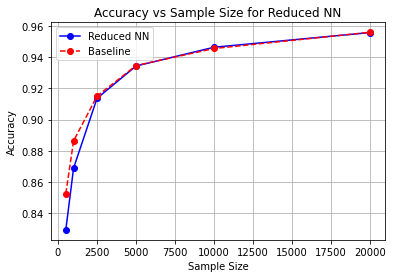

In [100]:
sample_sizes = [500, 1000, 2500, 5000, 10000, 20000]
baseline_accuracies = [0.8526, 0.8864, 0.915, 0.9346, 0.9455, 0.9559]

# Plotting the graph
plt.plot(sample_sizes, rnn_accuracies, marker='o', linestyle='-', color='blue', label='Reduced NN')
plt.plot(sample_sizes, baseline_accuracies, marker='o', linestyle='--', color='red', label='Baseline')

# Adding labels and title
plt.title('Accuracy vs Sample Size for Reduced NN')
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')

# Adding a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

## Generalized Condensed Nearest Neighbor (GCNN)

- **Algorithm Description:**
  - GCNN is an enhancement of the Condensed Nearest Neighbors (CNN) algorithm.
  - The initial prototypes are selected as the most voted from each class, with a vote being the nearest instance to others of the same class.

- **Prototype Selection:**
  - Prototypes are initially chosen based on a voting mechanism, emphasizing instances that are nearest to others within the same class.
  - This approach aims to capture representative examples for each class.

- **CNN Rule Application:**
  - The CNN rule is then applied, refining the set of prototypes.
  - A new instance x is considered classified correctly if its nearest neighbor xi in S is from the same class.
  - Additionally, the distance between x and xi must be lower than a threshold dist.

- **Threshold Consideration:**
  - The threshold dist is determined by the distance between x and its nearest enemy in S.
  - This ensures that instances are only considered correctly classified if they are sufficiently close to their nearest neighbors.

In [ ]:
def generalized_cnn(x_train, y_train, dist_threshold=1.0):
    S_indices = set()
    knn_classifier = KNeighborsClassifier(n_neighbors=1)

    misclassified = True
    while misclassified:
        misclassified = False

        # Check if S_indices is not empty before fitting the classifier
        if S_indices:
            knn_classifier.fit(x_train[list(S_indices)], y_train[list(S_indices)])
        else:
            # If S_indices is empty, break the loop and fit the classifier outside the loop
            break

        for class_label in np.unique(y_train):
            class_indices = np.where(y_train == class_label)[0]
            if len(class_indices) > 0:
                # Find the most voted instance from each class
                votes = np.zeros(len(class_indices))

                for i, idx in enumerate(class_indices):
                    x_instance = x_train[idx].reshape(1, -1)
                    distances, indices = knn_classifier.kneighbors(x_instance, n_neighbors=2)

                    if y_train[indices[0][1]] == class_label:
                        votes[i] += 1

                most_voted_idx = class_indices[np.argmax(votes)]
                S_indices.add(most_voted_idx)

    # Fit the classifier outside the loop when S_indices is empty
    if S_indices:
        knn_classifier.fit(x_train[list(S_indices)], y_train[list(S_indices)])

    remove_indices = []
    for i, (x, y) in enumerate(zip(x_train, y_train)):
        x_instance = x.reshape(1, -1)
        y_pred = knn_classifier.predict(x_instance)

        if y_pred != y:
            # Find the nearest neighbor in S and its class
            distances, indices = knn_classifier.kneighbors(x_instance, n_neighbors=2)
            nearest_neighbor_class = y_train[indices[0][1]]
            nearest_neighbor_distance = distances[0][1]

            # Find the nearest enemy in S
            enemy_indices = np.where(y_train != y)[0]
            enemy_distances, enemy_indices = knn_classifier.kneighbors(x_instance, n_neighbors=1, indices=enemy_indices)
            nearest_enemy_distance = enemy_distances[0][0]

            # Check the GCNN rule
            if nearest_neighbor_class == y and nearest_neighbor_distance < dist_threshold * nearest_enemy_distance:
                misclassified = True
                remove_indices.append(i)

    # Update S by removing instances that don't satisfy the GCNN rule
    S_indices -= set(remove_indices)

    # Generate a subset of the results of CNN algorithm
    x_train_gcnn = x_train[list(S_indices)]
    y_train_gcnn = y_train[list(S_indices)]

    return x_train_gcnn, y_train_gcnn

# Assuming x_data and y_data are your complete dataset and labels
total_trials = 2
gcnn_accuracies = []
for M in [500, 1000, 2500, 5000, 10000, 20000]:
    # Apply GCNN
    x_train_gcnn, y_train_gcnn = generalized_cnn(x_train, y_train, dist_threshold=1.0)

    # Train and evaluate nearest neighbor on the updated training set
    gcnn_accuracy = nearest_neighbor((x_train_gcnn, y_train_gcnn), (x_test, y_test))
    gcnn_accuracies.append(gcnn_accuracy)
    print(f'Accuracy for {M}: {gcnn_accuracy}')

print(gcnn_accuracies)
